In [66]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import numpy as np
from os import path
from datetime import datetime, date, timedelta

from mock_shiny_inputs import Input

input = Input()

In [21]:
df_fondsen = pd.read_csv("fondsen.csv")
df_fondsen = df_fondsen.dropna()
df_fondsen = df_fondsen.set_index("id")
df_fondsen

,file_name,directory,name
id,,,
0P0000AA58,0P0000AA58 Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
0P0000AA59,0P0000AA59 Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
0P0000AA5A,0P0000AA5A Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
0P0000XZ4E,0P0000XZ4E Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Core Fund Bala...
0P0000XZ4F,0P0000XZ4F Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Core Fund Bala...
LP65104373,LP65104373 Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
LP65104374,LP65104374 Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
LP65104375,LP65104375 Historical Data.csv,Ing,Ing (b) Collect Portfolio - Ing Personal Portf...
0P00000N68,0P00000N68 Historical Data.csv,DPam,Dpam B - Balanced Growth A


## Functies

In [22]:
def df_mnd_stortingen(df):
    storting_datums = df[df["Datum"].dt.day >= input.in_dag_storting()].groupby("Maand")["Datum"].min()
    storting_datums

    df_storting_datums = df[df["Datum"].isin(storting_datums)].copy()
    df_storting_datums["Aandelen"] = input.in_bedrag_storting() / df_storting_datums["Koers"]

    return df_storting_datums

In [23]:
def df_mnd_verkoop_datums(df):
    verkoop_datums = df[df["Datum"].dt.day >= input.in_dag_verkoop()].groupby("Maand")["Datum"].min()

    df_verkoop_dt = df[df["Datum"].isin(verkoop_datums)].copy()

    return df_verkoop_dt

In [24]:
from calc import *

In [29]:
for f_id in df_fondsen.index[0:1]:
    file_name = df_fondsen.loc[f_id,"file_name"]
    directory = df_fondsen.loc[f_id,"directory"]
    name = df_fondsen.loc[f_id,"name"]
    
    save_path = path.join("Pre", f_id + ".csv")
    
    file_path = path.join("Data", directory, file_name)
    
    if path.exists(save_path):
        continue
        
    df = pd.read_csv(file_path, parse_dates=["Date"])
    df = df.rename(columns={"Date": "Datum", "Price": "Koers"})
    df = df[["Datum","Koers"]]
    if df["Koers"].dtype == "object":
        df["Koers"] = df["Koers"].str.replace(",","").astype(float)
    df["Maand"] = df["Datum"].apply(lambda x: x.replace(day=1))
    
    print(df.head())
    df_stortingen = df_mnd_stortingen(df)
    
    df_verkoop = df_mnd_verkoop_datums(df)
    df_stortingen_verkoop = pd.merge(df_stortingen["Datum"], df_verkoop["Datum"], how="cross", suffixes=("_Eerste_Storting","_Verkoop"))
    df_stortingen_verkoop = df_stortingen_verkoop[df_stortingen_verkoop["Datum_Verkoop"] > df_stortingen_verkoop["Datum_Eerste_Storting"]]
    
    #df_stortingen_verkoop[["Investering Totaal","Verkoop Totaal","Winst Pct", "Eff Interest"]] = df_stortingen_verkoop.apply(lambda x: ji(df,
    df_stortingen_verkoop.apply(lambda x: ji(df,
        df_stortingen,
        x["Datum_Eerste_Storting"],
        x["Datum_Verkoop"],
        input.in_instapkost_pct(),
        input.in_verkoop_sper_periode(),
        input.in_min_stortingen_voor_verkoop()), axis=1, result_type="expand")
    
    print(df_stortingen_verkoop)
    print("Saving to {}".format(save_path))
    df_stortingen_verkoop.to_csv(save_path)

       Datum   Koers      Maand
0 2023-01-19  411.49 2023-01-01
1 2023-01-18  413.93 2023-01-01
2 2023-01-17  414.53 2023-01-01
3 2023-01-16  413.36 2023-01-01
4 2023-01-13  412.81 2023-01-01


TypeError: cannot unpack non-iterable float object

## Display

In [60]:
dfd = pd.read_csv("Pre\\0P0000AA58.csv", parse_dates=["Datum_Eerste_Storting","Datum_Verkoop"])
dfd
dfd = dfd[np.abs(dfd["Eff Interest"]) <= 15]
dfd

,Unnamed: 0,Datum_Eerste_Storting,Datum_Verkoop,Investering Totaal,Verkoop Totaal,Winst Pct,Eff Interest
22,463,2022-06-10,2022-11-21,3.0,2.859072,-4.697613,-12.351562
24,465,2022-06-10,2022-09-20,1.0,0.964801,-3.519931,-12.035156
29,529,2022-05-10,2022-11-21,4.0,3.816841,-4.578974,-10.875000
31,531,2022-05-10,2022-09-20,2.0,1.915439,-4.228027,-12.562500
32,532,2022-05-10,2022-08-22,1.0,1.002999,0.299948,1.054688
...,...,...,...,...,...,...,...
2203,4414,2017-07-20,2018-02-20,5.0,4.910961,-1.780776,-3.992188
2204,4415,2017-07-20,2018-01-22,4.0,4.093034,2.325861,5.882812
2205,4416,2017-07-20,2017-12-20,3.0,3.021094,0.703132,2.015625
2206,4417,2017-07-20,2017-11-20,2.0,1.996412,-0.179395,-0.585938


In [40]:
n_dt_stortingen = int(dfd["Datum_Eerste_Storting"].drop_duplicates().count())
n_dt_verkoop = int(dfd["Datum_Verkoop"].drop_duplicates().count())
n_dt_stortingen, n_dt_verkoop

(60, 63)

In [81]:
fig = px.density_heatmap(dfd, 
                         x="Datum_Eerste_Storting", 
                         y="Datum_Verkoop", 
                         z="Eff Interest", 
                         nbinsx=n_dt_stortingen, 
                         nbinsy=n_dt_verkoop, 
                         histfunc="avg", 
                         color_continuous_scale=["red","white","lime"],
                         color_continuous_midpoint=0,
                         height=1200,
                         hover_data=["Investering Totaal","Verkoop Totaal", "Winst Pct", "Eff Interest"]
                         )
fig.update_traces(dict(color_scale=["red","white","lime"],showscale=True,coloraxis=None))
fig

ValueError: Invalid property specified for object of type plotly.graph_objs.Histogram2d: 'color'

Did you mean "colorbar"?

    Valid properties:
        autobinx
            Obsolete: since v1.42 each bin attribute is auto-
            determined separately and `autobinx` is not needed.
            However, we accept `autobinx: true` or `false` and will
            update `xbins` accordingly before deleting `autobinx`
            from the trace.
        autobiny
            Obsolete: since v1.42 each bin attribute is auto-
            determined separately and `autobiny` is not needed.
            However, we accept `autobiny: true` or `false` and will
            update `ybins` accordingly before deleting `autobiny`
            from the trace.
        autocolorscale
            Determines whether the colorscale is a default palette
            (`autocolorscale: true`) or the palette determined by
            `colorscale`. In case `colorscale` is unspecified or
            `autocolorscale` is true, the default palette will be
            chosen according to whether numbers in the `color`
            array are all positive, all negative or mixed.
        bingroup
            Set the `xbingroup` and `ybingroup` default prefix For
            example, setting a `bingroup` of 1 on two histogram2d
            traces will make them their x-bins and y-bins match
            separately.
        coloraxis
            Sets a reference to a shared color axis. References to
            these shared color axes are "coloraxis", "coloraxis2",
            "coloraxis3", etc. Settings for these shared color axes
            are set in the layout, under `layout.coloraxis`,
            `layout.coloraxis2`, etc. Note that multiple color
            scales can be linked to the same color axis.
        colorbar
            :class:`plotly.graph_objects.histogram2d.ColorBar`
            instance or dict with compatible properties
        colorscale
            Sets the colorscale. The colorscale must be an array
            containing arrays mapping a normalized value to an rgb,
            rgba, hex, hsl, hsv, or named color string. At minimum,
            a mapping for the lowest (0) and highest (1) values are
            required. For example, `[[0, 'rgb(0,0,255)'], [1,
            'rgb(255,0,0)']]`. To control the bounds of the
            colorscale in color space, use `zmin` and `zmax`.
            Alternatively, `colorscale` may be a palette name
            string of the following list: Blackbody,Bluered,Blues,C
            ividis,Earth,Electric,Greens,Greys,Hot,Jet,Picnic,Portl
            and,Rainbow,RdBu,Reds,Viridis,YlGnBu,YlOrRd.
        customdata
            Assigns extra data each datum. This may be useful when
            listening to hover, click and selection events. Note
            that, "scatter" traces also appends customdata items in
            the markers DOM elements
        customdatasrc
            Sets the source reference on Chart Studio Cloud for
            `customdata`.
        histfunc
            Specifies the binning function used for this histogram
            trace. If "count", the histogram values are computed by
            counting the number of values lying inside each bin. If
            "sum", "avg", "min", "max", the histogram values are
            computed using the sum, the average, the minimum or the
            maximum of the values lying inside each bin
            respectively.
        histnorm
            Specifies the type of normalization used for this
            histogram trace. If "", the span of each bar
            corresponds to the number of occurrences (i.e. the
            number of data points lying inside the bins). If
            "percent" / "probability", the span of each bar
            corresponds to the percentage / fraction of occurrences
            with respect to the total number of sample points
            (here, the sum of all bin HEIGHTS equals 100% / 1). If
            "density", the span of each bar corresponds to the
            number of occurrences in a bin divided by the size of
            the bin interval (here, the sum of all bin AREAS equals
            the total number of sample points). If *probability
            density*, the area of each bar corresponds to the
            probability that an event will fall into the
            corresponding bin (here, the sum of all bin AREAS
            equals 1).
        hoverinfo
            Determines which trace information appear on hover. If
            `none` or `skip` are set, no information is displayed
            upon hovering. But, if `none` is set, click and hover
            events are still fired.
        hoverinfosrc
            Sets the source reference on Chart Studio Cloud for
            `hoverinfo`.
        hoverlabel
            :class:`plotly.graph_objects.histogram2d.Hoverlabel`
            instance or dict with compatible properties
        hovertemplate
            Template string used for rendering the information that
            appear on hover box. Note that this will override
            `hoverinfo`. Variables are inserted using %{variable},
            for example "y: %{y}" as well as %{xother}, {%_xother},
            {%_xother_}, {%xother_}. When showing info for several
            points, "xother" will be added to those with different
            x positions from the first point. An underscore before
            or after "(x|y)other" will add a space on that side,
            only when this field is shown. Numbers are formatted
            using d3-format's syntax %{variable:d3-format}, for
            example "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. The variables available in
            `hovertemplate` are the ones emitted as event data
            described at this link
            https://plotly.com/javascript/plotlyjs-events/#event-
            data. Additionally, every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variable `z` Anything contained in tag
            `<extra>` is displayed in the secondary box, for
            example "<extra>{fullData.name}</extra>". To hide the
            secondary box completely, use an empty tag
            `<extra></extra>`.
        hovertemplatesrc
            Sets the source reference on Chart Studio Cloud for
            `hovertemplate`.
        ids
            Assigns id labels to each datum. These ids for object
            constancy of data points during animation. Should be an
            array of strings, not numbers or any other type.
        idssrc
            Sets the source reference on Chart Studio Cloud for
            `ids`.
        legendgroup
            Sets the legend group for this trace. Traces part of
            the same legend group hide/show at the same time when
            toggling legend items.
        legendgrouptitle
            :class:`plotly.graph_objects.histogram2d.Legendgrouptit
            le` instance or dict with compatible properties
        legendrank
            Sets the legend rank for this trace. Items and groups
            with smaller ranks are presented on top/left side while
            with `*reversed* `legend.traceorder` they are on
            bottom/right side. The default legendrank is 1000, so
            that you can use ranks less than 1000 to place certain
            items before all unranked items, and ranks greater than
            1000 to go after all unranked items.
        legendwidth
            Sets the width (in px or fraction) of the legend for
            this trace.
        marker
            :class:`plotly.graph_objects.histogram2d.Marker`
            instance or dict with compatible properties
        meta
            Assigns extra meta information associated with this
            trace that can be used in various text attributes.
            Attributes such as trace `name`, graph, axis and
            colorbar `title.text`, annotation `text`
            `rangeselector`, `updatemenues` and `sliders` `label`
            text all support `meta`. To access the trace `meta`
            values in an attribute in the same trace, simply use
            `%{meta[i]}` where `i` is the index or key of the
            `meta` item in question. To access trace `meta` in
            layout attributes, use `%{data[n[.meta[i]}` where `i`
            is the index or key of the `meta` and `n` is the trace
            index.
        metasrc
            Sets the source reference on Chart Studio Cloud for
            `meta`.
        name
            Sets the trace name. The trace name appear as the
            legend item and on hover.
        nbinsx
            Specifies the maximum number of desired bins. This
            value will be used in an algorithm that will decide the
            optimal bin size such that the histogram best
            visualizes the distribution of the data. Ignored if
            `xbins.size` is provided.
        nbinsy
            Specifies the maximum number of desired bins. This
            value will be used in an algorithm that will decide the
            optimal bin size such that the histogram best
            visualizes the distribution of the data. Ignored if
            `ybins.size` is provided.
        opacity
            Sets the opacity of the trace.
        reversescale
            Reverses the color mapping if true. If true, `zmin`
            will correspond to the last color in the array and
            `zmax` will correspond to the first color.
        showlegend
            Determines whether or not an item corresponding to this
            trace is shown in the legend.
        showscale
            Determines whether or not a colorbar is displayed for
            this trace.
        stream
            :class:`plotly.graph_objects.histogram2d.Stream`
            instance or dict with compatible properties
        textfont
            Sets the text font.
        texttemplate
            Template string used for rendering the information text
            that appear on points. Note that this will override
            `textinfo`. Variables are inserted using %{variable},
            for example "y: %{y}". Numbers are formatted using
            d3-format's syntax %{variable:d3-format}, for example
            "Price: %{y:$.2f}".
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format
            for details on the formatting syntax. Dates are
            formatted using d3-time-format's syntax
            %{variable|d3-time-format}, for example "Day:
            %{2019-01-01|%A}". https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format for details on the
            date formatting syntax. Every attributes that can be
            specified per-point (the ones that are `arrayOk: true`)
            are available. variable `z`
        uid
            Assign an id to this trace, Use this to provide object
            constancy between traces during animations and
            transitions.
        uirevision
            Controls persistence of some user-driven changes to the
            trace: `constraintrange` in `parcoords` traces, as well
            as some `editable: true` modifications such as `name`
            and `colorbar.title`. Defaults to `layout.uirevision`.
            Note that other user-driven trace attribute changes are
            controlled by `layout` attributes: `trace.visible` is
            controlled by `layout.legend.uirevision`,
            `selectedpoints` is controlled by
            `layout.selectionrevision`, and `colorbar.(x|y)`
            (accessible with `config: {editable: true}`) is
            controlled by `layout.editrevision`. Trace changes are
            tracked by `uid`, which only falls back on trace index
            if no `uid` is provided. So if your app can add/remove
            traces before the end of the `data` array, such that
            the same trace has a different index, you can still
            preserve user-driven changes if you give each trace a
            `uid` that stays with it as it moves.
        visible
            Determines whether or not this trace is visible. If
            "legendonly", the trace is not drawn, but can appear as
            a legend item (provided that the legend itself is
            visible).
        x
            Sets the sample data to be binned on the x axis.
        xaxis
            Sets a reference between this trace's x coordinates and
            a 2D cartesian x axis. If "x" (the default value), the
            x coordinates refer to `layout.xaxis`. If "x2", the x
            coordinates refer to `layout.xaxis2`, and so on.
        xbingroup
            Set a group of histogram traces which will have
            compatible x-bin settings. Using `xbingroup`,
            histogram2d and histogram2dcontour traces  (on axes of
            the same axis type) can have compatible x-bin settings.
            Note that the same `xbingroup` value can be used to set
            (1D) histogram `bingroup`
        xbins
            :class:`plotly.graph_objects.histogram2d.XBins`
            instance or dict with compatible properties
        xcalendar
            Sets the calendar system to use with `x` date data.
        xgap
            Sets the horizontal gap (in pixels) between bricks.
        xhoverformat
            Sets the hover text formatting rulefor `x`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `xaxis.hoverformat`.
        xsrc
            Sets the source reference on Chart Studio Cloud for
            `x`.
        y
            Sets the sample data to be binned on the y axis.
        yaxis
            Sets a reference between this trace's y coordinates and
            a 2D cartesian y axis. If "y" (the default value), the
            y coordinates refer to `layout.yaxis`. If "y2", the y
            coordinates refer to `layout.yaxis2`, and so on.
        ybingroup
            Set a group of histogram traces which will have
            compatible y-bin settings. Using `ybingroup`,
            histogram2d and histogram2dcontour traces  (on axes of
            the same axis type) can have compatible y-bin settings.
            Note that the same `ybingroup` value can be used to set
            (1D) histogram `bingroup`
        ybins
            :class:`plotly.graph_objects.histogram2d.YBins`
            instance or dict with compatible properties
        ycalendar
            Sets the calendar system to use with `y` date data.
        ygap
            Sets the vertical gap (in pixels) between bricks.
        yhoverformat
            Sets the hover text formatting rulefor `y`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see:
            https://github.com/d3/d3-format/tree/v1.4.5#d3-format.
            And for dates see: https://github.com/d3/d3-time-
            format/tree/v2.2.3#locale_format. We add two items to
            d3's date formatter: "%h" for half of the year as a
            decimal number as well as "%{n}f" for fractional
            seconds with n digits. For example, *2016-10-13
            09:15:23.456* with tickformat "%H~%M~%S.%2f" would
            display *09~15~23.46*By default the values are
            formatted using `yaxis.hoverformat`.
        ysrc
            Sets the source reference on Chart Studio Cloud for
            `y`.
        z
            Sets the aggregation data.
        zauto
            Determines whether or not the color domain is computed
            with respect to the input data (here in `z`) or the
            bounds set in `zmin` and `zmax` Defaults to `false`
            when `zmin` and `zmax` are set by the user.
        zhoverformat
            Sets the hover text formatting rulefor `z`  using d3
            formatting mini-languages which are very similar to
            those in Python. For numbers, see: https://github.com/d
            3/d3-format/tree/v1.4.5#d3-format.By default the values
            are formatted using generic number format.
        zmax
            Sets the upper bound of the color domain. Value should
            have the same units as in `z` and if set, `zmin` must
            be set as well.
        zmid
            Sets the mid-point of the color domain by scaling
            `zmin` and/or `zmax` to be equidistant to this point.
            Value should have the same units as in `z`. Has no
            effect when `zauto` is `false`.
        zmin
            Sets the lower bound of the color domain. Value should
            have the same units as in `z` and if set, `zmax` must
            be set as well.
        zsmooth
            Picks a smoothing algorithm use to smooth `z` data.
        zsrc
            Sets the source reference on Chart Studio Cloud for
            `z`.
        
Did you mean "colorbar"?

Bad property path:
color_continuous_scale
^^^^^

In [62]:
dfd["Jaar Eerste Storting"] = dfd["Datum_Eerste_Storting"].dt.year

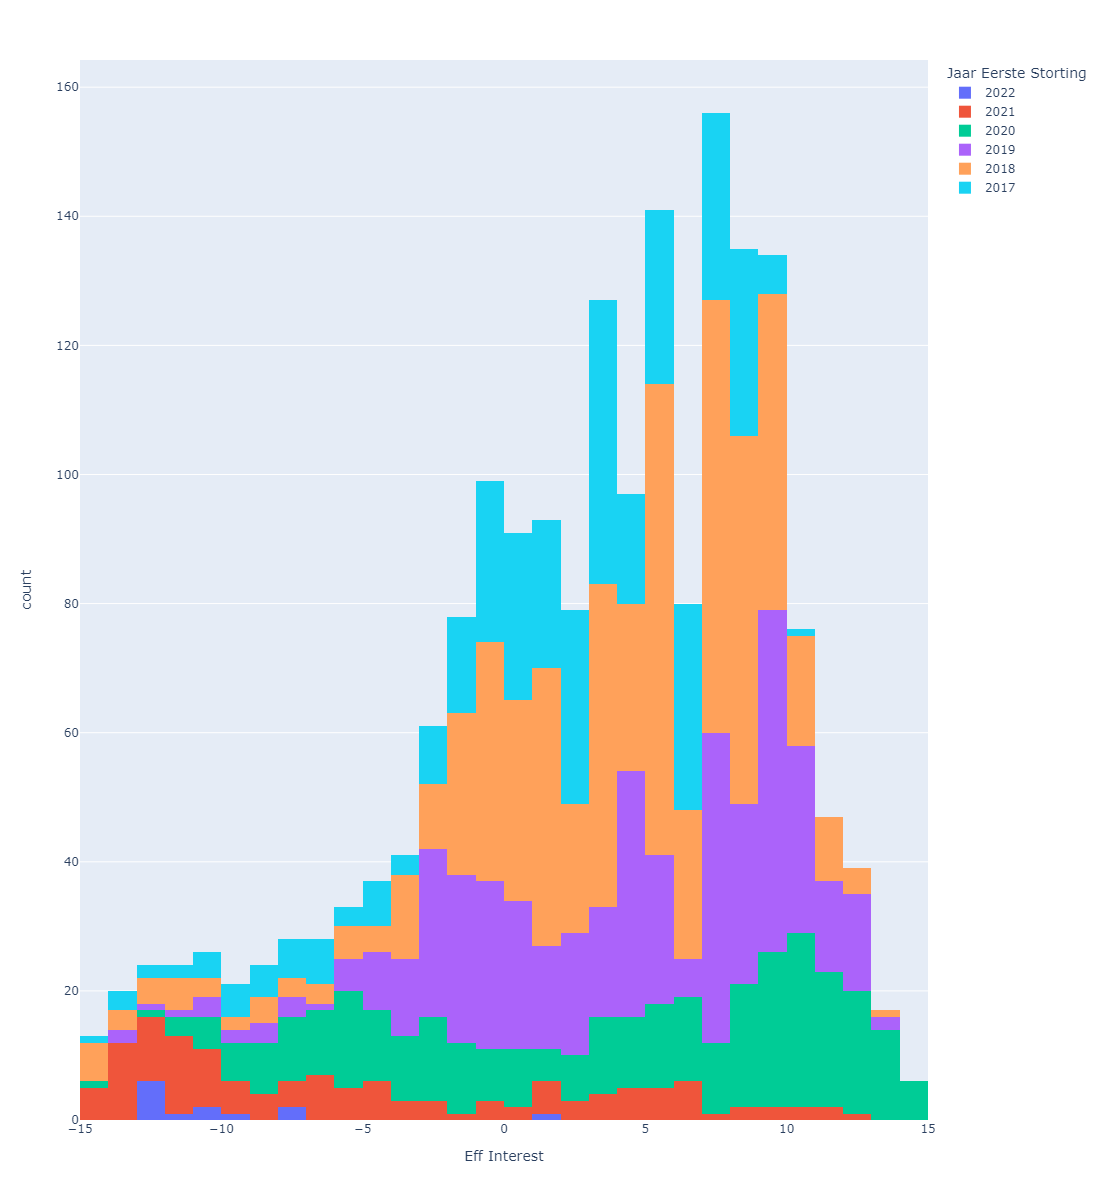

In [65]:
px.histogram(dfd, x="Eff Interest", color="Jaar Eerste Storting", height=1200)

In [72]:
min_year = dfd["Jaar Eerste Storting"].min()
max_year = dfd["Jaar Eerste Storting"].max()

year_list = [dfd["Eff Interest"][dfd["Jaar Eerste Storting"] == jaar] for jaar in range(min_year, max_year+1)]

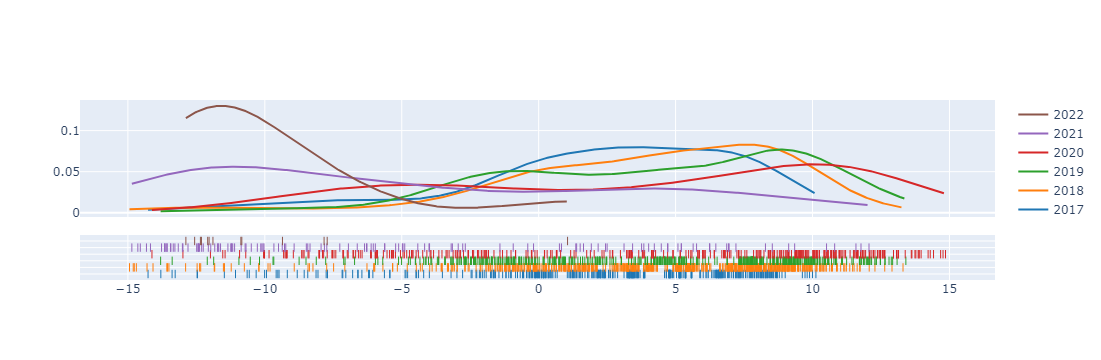

In [76]:
fig = ff.create_distplot(year_list, range(min_year, max_year+1), show_hist=False)
fig

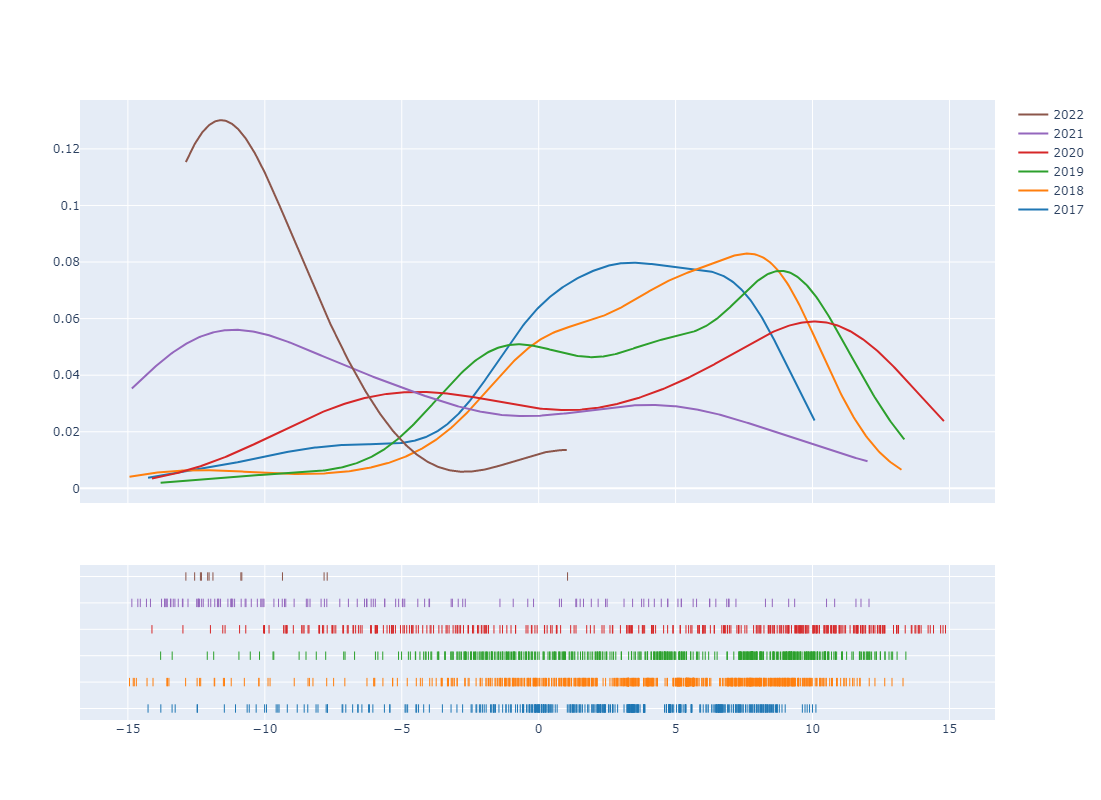

In [78]:
fig.update_layout(height=800)
fig